# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [101]:
%pip install git+https://github.com/alemartinello/dstapi
# A wrapper for multiple APIs with a pandas interface
#%pip install pandas-datareader

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/05/z6z0pv093xnbwyg0ggtl3kwh0000gn/T/pip-req-build-o_6_cz65
  Running command git clone -q https://github.com/alemartinello/dstapi /private/var/folders/05/z6z0pv093xnbwyg0ggtl3kwh0000gn/T/pip-req-build-o_6_cz65
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
Note: you may need to restart the kernel to use updated packages.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from matplotlib_venn import venn2
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

In [103]:
ind = DstApi('GF02') 

In [104]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table GF02: General enterprise statistics by Municipality, Industry (DB07 10- 19- and 127 grouping and detailed), enterprise size (full time equivalents) and time
Last update: 2023-05-05T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOMK,118,000,All Denmark,12,Outside from Denmark,False
1,BRANCHEDB0710TIL127,902,TOT,TOT Industry total,999999,999999 Activity not stated,False
2,FIRMSTR,6,TOT,"Total, all enterprises",103,250 employees and more,False
3,Tid,15,2007,2007,2021,2021,True


In [105]:
# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(ind.variable_levels(variable, language='en'))

KOMK:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
113,820,Vesthimmerlands
114,851,Aalborg
115,099,Region unknown
116,098,Municipality unknown


BRANCHEDB0710TIL127:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,A,"A Agriculture, forestry and fishing"
3,01000,01000 Agriculture and horticulture
4,011100,"011100 Growing of cereals (except rice), legum..."
...,...,...
897,990000,990000 Activities of extraterritorial organiza...
898,11,11 Activity not stated
899,X,X Activity not stated
900,99999,99999 Activity not stated


FIRMSTR:


,id,text
0,TOT,"Total, all enterprises"
1,0000,No employed
2,010,Less than 10 employed
3,101,10-49 employees
4,102,50-249 employees
5,103,250 employees and more


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [106]:
params = ind._define_base_params(language='en')
params

{'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['*']},
  {'code': 'BRANCHEDB0710TIL127', 'values': ['*']},
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [107]:
params1 = {'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['*']},
  {'code': 'BRANCHEDB0710TIL127', 'values': ['TOT', '1','2','3','4','5','6','7','8','9','10','11']},
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [108]:
inc_api = ind.get_data(params=params1)
inc_api.head(5)

,KOMK,BRANCHEDB0710TIL127,FIRMSTR,TID,INDHOLD
0,Brøndby,TOT Industry total,"Total, all enterprises",2007,1588
1,Brøndby,TOT Industry total,No employed,2007,652
2,Brøndby,TOT Industry total,Less than 10 employed,2007,653
3,Brøndby,TOT Industry total,10-49 employees,2007,217
4,Brøndby,TOT Industry total,50-249 employees,2007,51


In [109]:
inc_api.rename(columns = {'KOMK':'regions', 'BRANCHEDB0710TIL127':'industry', 'FIRMSTR': 'firm size', 'TID':'time', 'INDHOLD':'#firms'}, inplace=True)
inc_api.head()

,regions,industry,firm size,time,#firms
0,Brøndby,TOT Industry total,"Total, all enterprises",2007,1588
1,Brøndby,TOT Industry total,No employed,2007,652
2,Brøndby,TOT Industry total,Less than 10 employed,2007,653
3,Brøndby,TOT Industry total,10-49 employees,2007,217
4,Brøndby,TOT Industry total,50-249 employees,2007,51


In [110]:
I = inc_api.regions.str.contains('Region')
I |= inc_api.regions.str.contains('All Denmark')
inc_api.loc[I, :]

,regions,industry,firm size,time,#firms
152,All Denmark,"9 Public administration, education and health","Total, all enterprises",2012,24676
153,All Denmark,"9 Public administration, education and health",No employed,2012,11561
154,All Denmark,"9 Public administration, education and health",Less than 10 employed,2012,10269
155,All Denmark,"9 Public administration, education and health",10-49 employees,2012,2148
156,All Denmark,"9 Public administration, education and health",50-249 employees,2012,488
...,...,...,...,...,...
97344,Region Hovedstaden,3 Construction,No employed,2017,4171
97345,Region Hovedstaden,3 Construction,Less than 10 employed,2017,4614
97346,Region Hovedstaden,3 Construction,10-49 employees,2017,634
97347,Region Hovedstaden,3 Construction,50-249 employees,2017,83


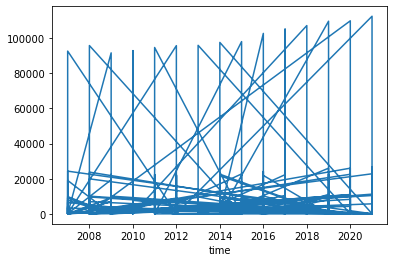

In [113]:
# Data frame
test1 = inc_api.loc[inc_api['regions'] == 'Region Hovedstaden']

# Plot the content of the data frame
test1.plot(x='time',y='#firms',legend=False);

In [ ]:
ind2 = DstApi('DEMO4')

In [ ]:
tabsum2 = ind2.tablesummary(language='en')
display(tabsum2)

In [ ]:
# The available values for a each variable: 
for variable in tabsum2['variable name']:
    print(variable+':')
    display(ind2.variable_levels(variable, language='en'))

Import your data, either through an API or manually, and load it. 

In [ ]:
params = ind2._define_base_params(language='en')
params

In [ ]:
params2 = {'table': 'demo4',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'REGION', 'values': ['*']},
  {'code': 'BRANCHEDB0710', 'values': ['*']},
  {'code': 'MÆNGDE4', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [ ]:
inc_api2 = ind2.get_data(params=params2)
inc_api2.head(5)

In [ ]:
inc_api2.rename(columns = {'BRANCHEDB0710':'Industry', 'MÆNGDE4': 'X', 'TID':'Time', 'INDHOLD':'Total'}, inplace=True)
inc_api2.head()

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.